<div class="alert alert-block alert-info">

- See my comments in the blue boxes.

General idea:

- Use `#` in Markdown for headings. More `#` creates smaller headings (see: [Markdown Jupyter Cheatsheet](https://www.ibm.com/docs/en/watson-studio-local/1.2.3?topic=notebooks-markdown-jupyter-cheatsheet)).

- If a table and figure convey the same information, display only one. Refer to the details below.

- Include comments and headings for clarity in all figures and tables.

- Only print relevant content/stuff you plan to explain. Refer below.

</div>

s.

In [4]:
install.packages("kknn")
library(kknn)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [6]:
library(tidyverse)
library(DBI)
library(tidymodels)

In [11]:
url <- "https://raw.githubusercontent.com/Ivvvyyan/dsci-group-11/main/StressLevelDataset.csv"
stress <- read_csv(url)
head(stress, n = 3)

Rows: 1100 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (21): anxiety_level, self_esteem, mental_health_history, depression, hea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


anxiety_level,self_esteem,mental_health_history,depression,headache,blood_pressure,sleep_quality,breathing_problem,noise_level,living_conditions,⋯,basic_needs,academic_performance,study_load,teacher_student_relationship,future_career_concerns,social_support,peer_pressure,extracurricular_activities,bullying,stress_level
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
14,20,0,11,2,1,2,4,2,3,⋯,2,3,2,3,3,2,3,3,2,1
15,8,1,15,5,3,1,4,3,1,⋯,2,1,4,1,5,1,4,5,5,2
12,18,1,14,2,1,2,2,2,2,⋯,2,2,3,3,2,2,3,2,2,1


In [12]:
stress <- stress |>
    mutate(stress_level = as_factor(stress_level))|>
    mutate(stress_level = fct_recode(stress_level, "Carefree" = "0", "Intermediate" = "1", "Stressful" = "2"))

stress |>
    distinct(stress_level)

stress_level
<fct>
Intermediate
Stressful
Carefree


In [13]:
names(stress) <- c("anxiety_level", "self_esteem", "mental_health_history", "depression",
                  "headache", "blood_pressure", "sleep_quality", "breathing_problem",
                  "noise_level", "living_conditions", "safety", "basic_needs", 
                  "academic_performance", "study_load", "teacher_student_relationship", "future_career_concerns",
                  "social_support", "peer_pressure", "extracurricular_activities", "bullying", "stress_level")
head(stress, n=3)

anxiety_level,self_esteem,mental_health_history,depression,headache,blood_pressure,sleep_quality,breathing_problem,noise_level,living_conditions,⋯,basic_needs,academic_performance,study_load,teacher_student_relationship,future_career_concerns,social_support,peer_pressure,extracurricular_activities,bullying,stress_level
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
14,20,0,11,2,1,2,4,2,3,⋯,2,3,2,3,3,2,3,3,2,Intermediate
15,8,1,15,5,3,1,4,3,1,⋯,2,1,4,1,5,1,4,5,5,Stressful
12,18,1,14,2,1,2,2,2,2,⋯,2,2,3,3,2,2,3,2,2,Intermediate


In [14]:
#reports the distribution of distinct stress level
num_obs <- nrow(stress)
stress |>
  group_by(stress_level) |>
  summarize(
    count = n(),
    percentage = n() / num_obs * 100
  )

#reports the number of observations in each variable
num_observations <- stress |>
  summarise(across(everything(), ~sum(!is.na(.))))
num_observations

stress_level,count,percentage
<fct>,<int>,<dbl>
Carefree,373,33.90909
Intermediate,358,32.54545
Stressful,369,33.54545


anxiety_level,self_esteem,mental_health_history,depression,headache,blood_pressure,sleep_quality,breathing_problem,noise_level,living_conditions,⋯,basic_needs,academic_performance,study_load,teacher_student_relationship,future_career_concerns,social_support,peer_pressure,extracurricular_activities,bullying,stress_level
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,⋯,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100


<div class="alert alert-block alert-info"> 
can mention: the `num_obs` table shows that your data is balance = don't need to balance the data.
</div>a

The above tells us that our data does not have any missing (N/A) values. Therefore, we do not have to worry about removing NA values from our dataset!

<div class="alert alert-block alert-info">

- kinda confused here ⬇️ . Should select study_load and peer_pressure after your EDA.
- i.e. (1) eda figure demonstrated study_load and peer_pressure may be a good predictors to be used for classification (i.e. the boxplot ain't overlapping...expand on this). (2) Then, that's why you selected for only study_load and peer_pressure.


</div>



In [18]:
stress_selected <- stress |>
    select(study_load, peer_pressure, stress_level)

head(stress_selected, n = 5)

study_load,peer_pressure,stress_level
<dbl>,<dbl>,<fct>
2,3,Intermediate
4,4,Stressful
3,3,Intermediate
4,4,Stressful
3,5,Intermediate


<div class="alert alert-block alert-info">

don't need to print with nrow() ⬇️. Knowing how many rows here doesn't really matter atm.

</div>

In [16]:
set.seed(12345)
#Splitting the data into training and testing set.
stress_split <- initial_split(stress_selected, prop = 0.75, strata = stress_level)
stress_training <- training(stress_split)
stress_testing <- testing(stress_split)

# i commented this out.
# nrow(stress_training)
# nrow(stress_testing)

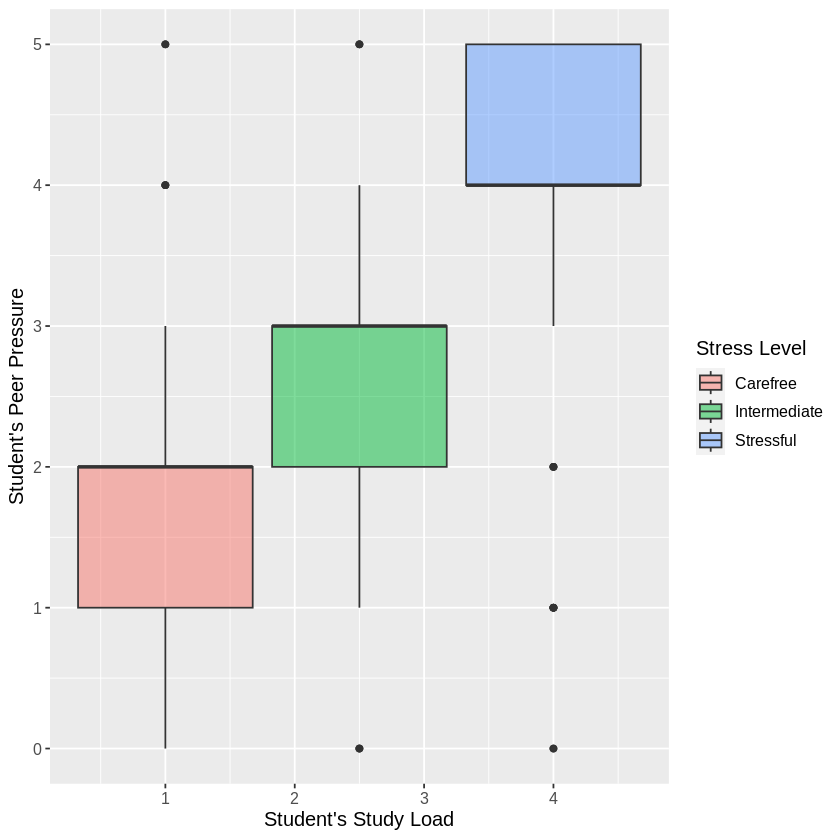

In [19]:
stress_academic <- stress_training |>
    ggplot(aes (x=study_load, y=peer_pressure, fill=stress_level)) +
    geom_boxplot(alpha = 0.5) +
    labs(x="Student's Study Load", y="Student's Peer Pressure", fill="Stress Level") +
    theme(text = element_text(size=12))

stress_academic

In [54]:
stress_vfold <- vfold_cv(stress_training, v=10, strata = stress_level)

In [55]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
set_engine("kknn") |>
set_mode("classification")

In [56]:
stress_recipe <- recipe(stress_level ~ ., data=stress_selected)

# I took out printing the recipe. Likely bc you don't plan to explain it.

<div class="alert alert-block alert-info">
 No need to print both the `accuracies` object and `accuracy_vs_k` object as they convey the same information. Otherwise, it would result in redundant explanations  .</div>>div>

<div class="alert alert-block alert-info">


Wondering: Why not initialize `k_vals` with `tibble(neighbors = seq(from = 1, to = 50, by = 1))` at the beginning? It could reduce the need for extra explanation for tunining it twices and potential confusion (unless the issue is that the student server is unable to run it)

Also set.seed here. Cross validation contain element of randomness.

</div>

.

In [70]:
# i've edit here.
# also set seed here to be safe. 

set.seed(1234)
k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

knn_results <- workflow() |>
    add_recipe(stress_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = stress_vfold, grid = k_vals) |>
    collect_metrics()

accuracies <- knn_results |>
    filter(.metric == "accuracy") 

# dont print
# accuracies

In [74]:
# same neighbour as below
accuracies_max <- knn_results |>
    filter(.metric == "accuracy") |>
    slice_max(mean)

accuracies_max

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
39,accuracy,multiclass,0.8178912,10,0.01582678,Preprocessor1_Model39


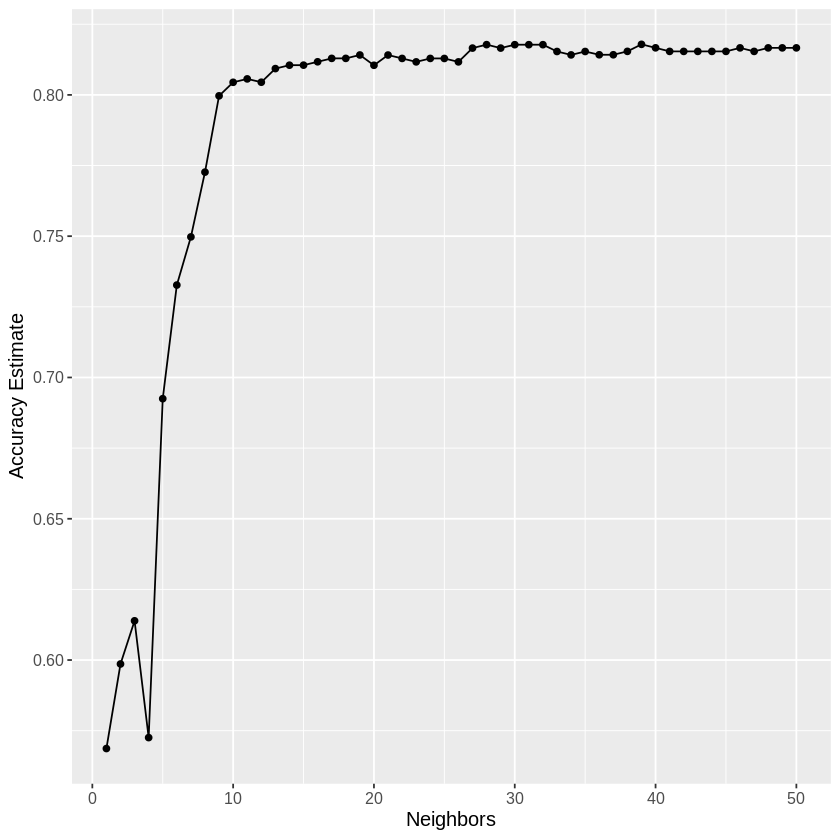

In [73]:
accuracy_vs_k <- ggplot(accuracies, aes(x=neighbors, y=mean)) +
    geom_point() +
    geom_line() +
    labs(x="Neighbors", y="Accuracy Estimate") +
    theme(text=element_text(size=12))

accuracy_vs_k

In [75]:
k_vals_2 <- tibble(neighbors = seq(from = 31, to = 41, by = 1))

knn_results_2 <- workflow() |>
    add_recipe(stress_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = stress_vfold, grid = k_vals_2) |>
    collect_metrics()

accuracies_2 <- knn_results_2 |>
    filter(.metric == "accuracy")

In [60]:
max_accuracy <- accuracies_2 |>
    slice_max(mean)
max_accuracy

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
39,accuracy,multiclass,0.8178912,10,0.01582678,Preprocessor1_Model09


In [43]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 31) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit <- workflow() |>
    add_recipe(stress_recipe) |>
    add_model(knn_spec) |>
    fit(data=stress_training)

## I've edited here
stress_test_predictions <- predict(knn_fit, stress_testing) |> # i used stress_testing in predict(), and not stress_testing_removed
    bind_cols(stress_testing)

head(stress_test_predictions, n = 3)

.pred_class,study_load,peer_pressure,stress_level
<fct>,<dbl>,<dbl>,<fct>
Stressful,4,4,Stressful
Intermediate,3,3,Intermediate
Stressful,5,4,Stressful


<div class="alert alert-block alert-info">
I'm not quite clear on why the header is removed before using it for prediction here ⬇️. Could you provide more details? Elsewise, what I've done above should do the trick.

In [34]:
stress_testing_removed <- stress_testing |>
    select(-stress_level)

head(stress_testing_removed, n=3)

study_load,peer_pressure
<dbl>,<dbl>
4,4
3,3
5,4


In [87]:
stress_test_predictions <- predict(knn_fit, stress_testing_removed) |>
    bind_cols(stress_testing)

head(stress_test_predictions, n=5)

.pred_class,study_load,peer_pressure,stress_level
<fct>,<dbl>,<dbl>,<fct>
Stressful,4,4,Stressful
Intermediate,3,3,Intermediate
Stressful,5,4,Stressful
Carefree,2,1,Carefree
Carefree,2,2,Intermediate


In [88]:
stress_accuracy <- stress_test_predictions |>
    metrics(truth=stress_level, estimate= .pred_class) |>
    filter(.metric == "accuracy")

stress_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7689531


<div class="alert alert-block alert-info">
The confusion matrix format looks right to me. 


The interpretation is same/similar for two-class classification. But for more detail, you can read the "Confusion matrix in multi-class classification" section of this page: https://www.evidentlyai.com/classification-metrics/confusion-matrix#:~:text=Confusion%20matrix%20in%20multi%2Dclass%20classification,-You%20can%20use&text=Their%20number%20depends%20on%20the,instances%20in%20a%20predicted%20class.





In [77]:
stress_confusion <- stress_test_predictions |>
    conf_mat(truth = stress_level, estimate = .pred_class)
stress_confusion

              Truth
Prediction     Carefree Intermediate Stressful
  Carefree           79           33        10
  Intermediate        5           53         2
  Stressful          10            4        81

<div class="alert alert-block alert-info">

Instead of displaying your confusion matrix in a 'conf.mat' format ⬆️, consider visualizing it as a figure ⬇️ to fulfill the 'creates a visualization of the analysis' criterion. While the method I've provided is quick, it lacks aesthetic appeal. You can explore for alternative code or try to find ways to make this more aesthetic (requires some googling).

Note: similarly, if you print it as a figure, don't print the 'conf.mat' format.)

</div>

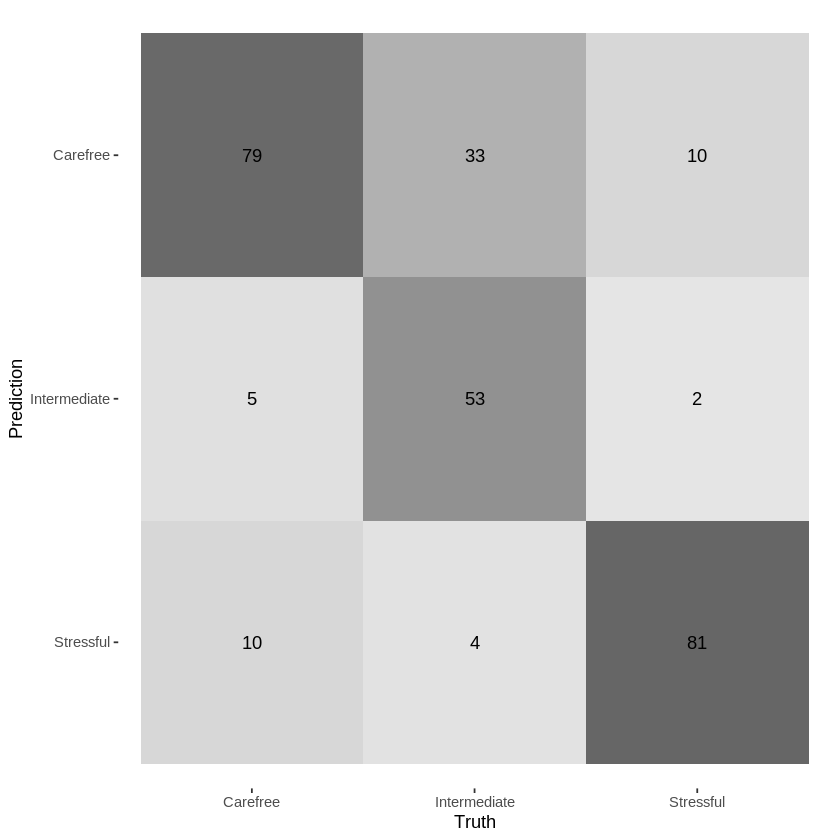

In [52]:
autoplot(stress_confusion, type = "heatmap")

In [80]:
accuracy <- (79+53+81)/(79+53+81+33+10+6+2+9+4)


precision_1 <- 79/(79+5+10)
precision_2 <- 53/(53+33+4)
precision_3 <- 81/(81+10+2)

precision <- (precision_1 + precision_2 + precision_3)/3


recall_1 <- 79/(79+33+10)
recall_2 <- 53/(53+5+2)
recall_3 <- 81/(81+10+4)

recall <- (recall_1 + recall_2 + recall_3)/3


# i've edit here

# Create a dataframe
metrics_df <- data.frame(
  Metric = c("Accuracy", "Precision", "Recall"),
  Value = c(accuracy, precision, recall)
)


metrics_df

Metric,Value
<chr>,<dbl>
Accuracy,0.7689531
Precision,0.7667607
Recall,0.7945020


<div class="alert alert-block alert-info">

Me being extra, but you can have your accuracy, precision, recall # ⬆️ in a dataframe/table. This way,you can refer to the number more easily for discussion.

